First, load the data,in this notebook we are using the Qitta data from the paper "Machine learning–based feature selection to search stable microbial biomarkers: application to inflammatory bowel disease". The data has been preprocessed in R (refer to the r script in iCloud/UTK/GRA-UTK/SelectMicro/MLonMicrobiome).

There are 3 datasets, the orginal paper combined the 3 datasets together, but not sure how they are combined since they have different columns. The imbalance is an issue if analyzing each dataset independently. In Qitta_full.ipynb, all the features are kept.

In [1]:
import sys
sys.path.append('../../../Code')
import loadData 
import RunML
import RunML_continue
import FS
import metric

import pandas as pd
import numpy as np
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import pickle

In [2]:
qitta_combine = pd.read_csv('../data/count_table/Qitta_3datasetscombined_full.csv',index_col=0)

In [3]:
print(qitta_combine.shape)

(1569, 15178)


In [4]:
print(qitta_combine)

               Diagnosis  X4479946  X4307314  X4376890  X337735  X347991  \
11484.CSM5FZ3X        CD       5.0       0.0       0.0      0.0      0.0   
11484.CSM5FZ3Z        CD       2.0       0.0       0.0      0.0      0.0   
11484.MSM5LLIQ        UC       1.0       6.0       2.0     10.0      0.0   
11484.CSM5FZ3N        CD       0.0       1.0       0.0      0.0      1.0   
11484.CSM5MCV5        CD       0.0       1.0       0.0      2.0      0.0   
...                  ...       ...       ...       ...      ...      ...   
2151.G10483       nonIBD       NaN       NaN       NaN      NaN      NaN   
2151.G11579       nonIBD       NaN       NaN       NaN      NaN      NaN   
2151.G11295       nonIBD       NaN       NaN       NaN      NaN      NaN   
2151.G11157       nonIBD       NaN       NaN       NaN      NaN      NaN   
2151.G10686       nonIBD       NaN       NaN       NaN      NaN      NaN   

                X181348  X4454356  X261920  X4474844  ...  X66199  X302312  \
11484.CSM

Extract OTU relative abundance table and response variable

In [5]:
data = qitta_combine.drop(qitta_combine.columns[0], axis=1)
cols_name = data.columns.tolist()
data = data.values

In [6]:
print(data)
print(np.shape(data))

[[ 5.  0.  0. ... nan nan nan]
 [ 2.  0.  0. ... nan nan nan]
 [ 1.  6.  2. ... nan nan nan]
 ...
 [nan nan nan ...  0.  0.  0.]
 [nan nan nan ...  0.  0.  0.]
 [nan nan nan ...  0.  0.  0.]]
(1569, 15177)


In [7]:
y = qitta_combine.iloc[:, 0].values 

In [8]:
set(y)

{'CD', 'UC', 'nonIBD'}

In [9]:
#change y into 2 levels
y = np.where(np.isin(y, ['CD', 'UC']), 'IBD', y)

In [10]:
y

array(['IBD', 'IBD', 'IBD', ..., 'nonIBD', 'nonIBD', 'nonIBD'],
      dtype=object)

In [11]:
# y is an array and y_lable is an series(pd.DataFrame)
y_lable = pd.DataFrame(y)
y_lable.value_counts()

0     
nonIBD    867
IBD       702
Name: count, dtype: int64

preprocess the OTU table

In [12]:
# 1. abundance matrix--> relative abundance matrix
data=FS.relative_abundance(data)
print(np.shape(data))

(1569, 15177)


Perform sigle lable feature selection, this is done by calculating Kruskal-Wallis H-test on each OTU for each environmental factor, each OTU/ASV is given a weighted h score.

In [13]:
# 2. calculating H score for each OTU
weights=FS.OTU_H_Score_fun(data,y)

In [14]:
print(min(weights));print(max(weights))

0.0
205.61608295746555


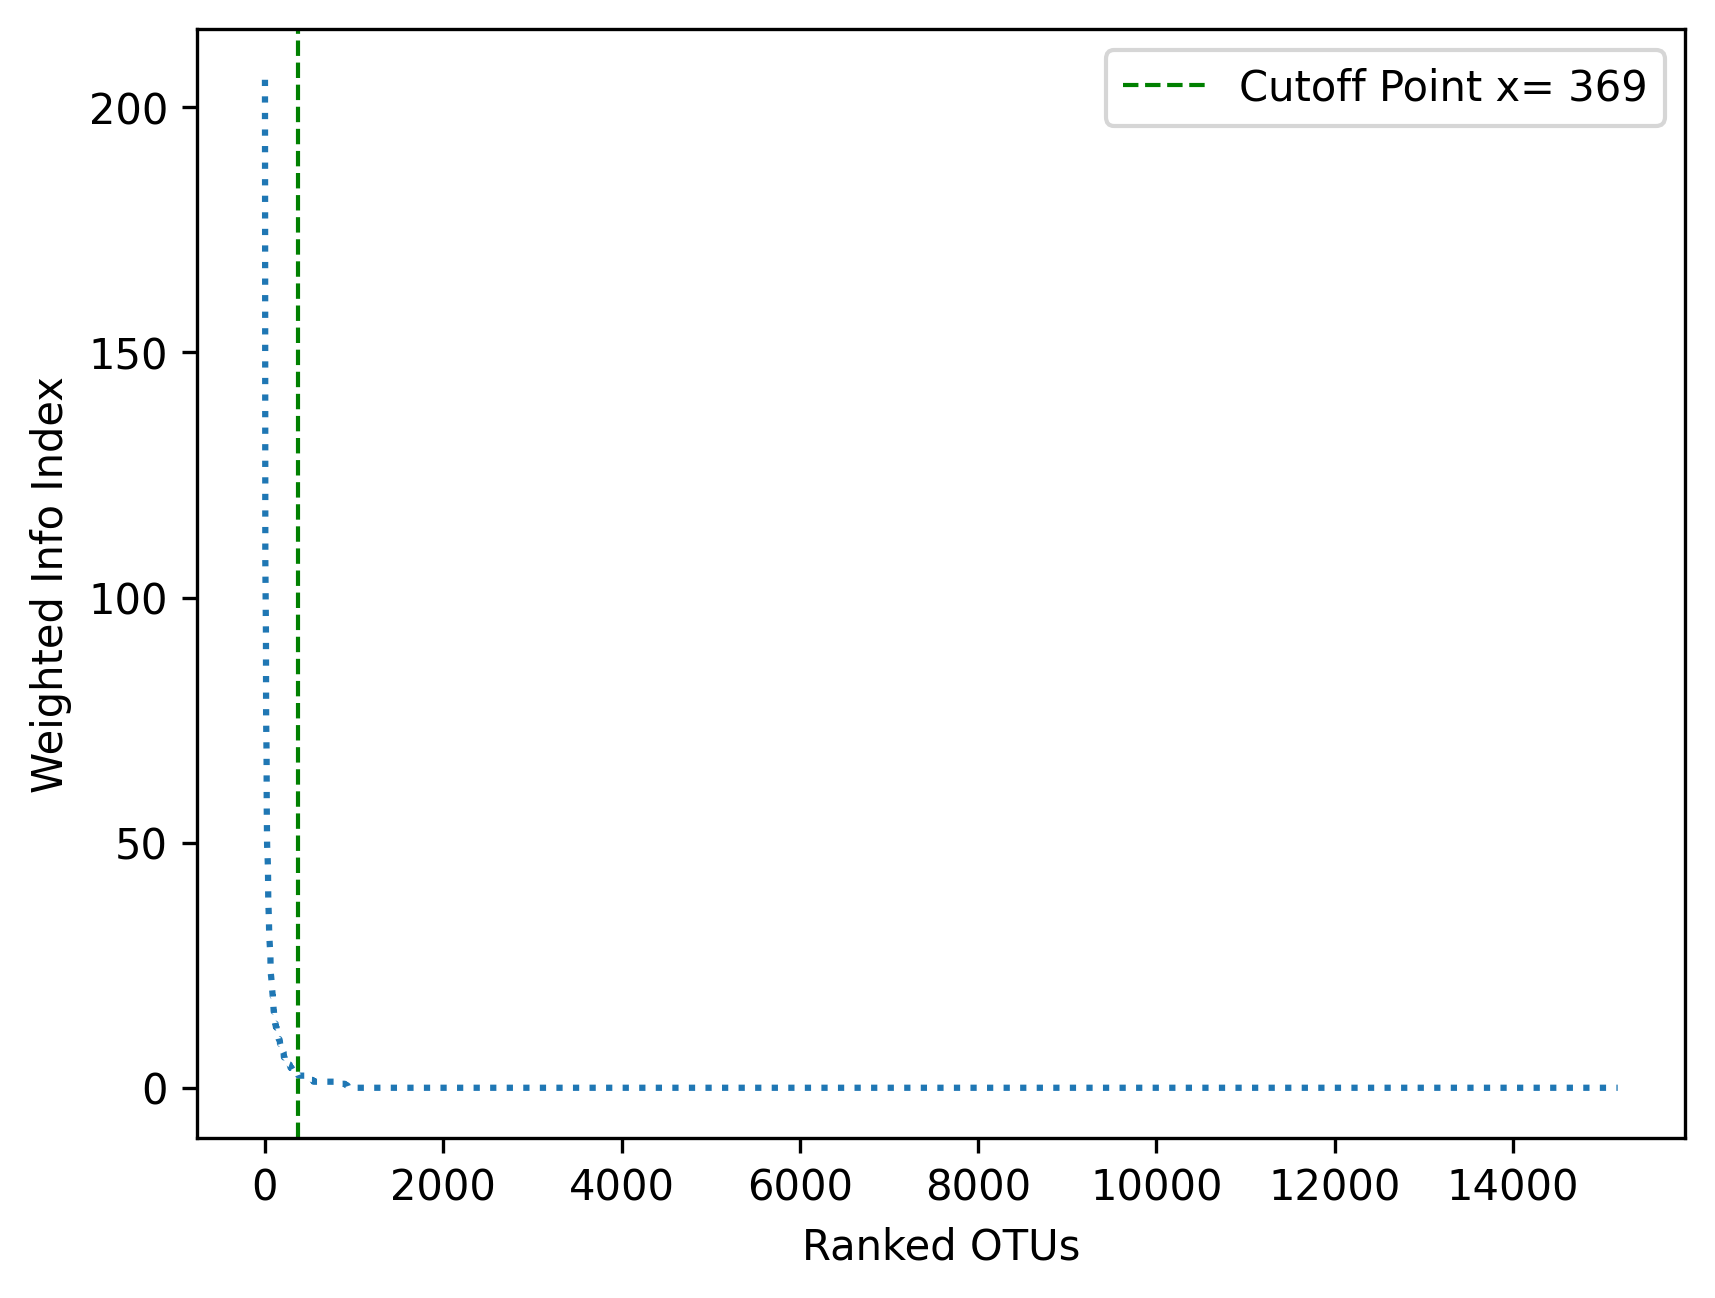

In [15]:
# 3. determine the elbowpoint and the select indices of the features
selectedOTU_index, eps=FS.indice_H_unisig(weights,y)
#plot the h statistics and cutoff descendingly
FS.plotWeightedIndex(weights,threshold=eps)

This plot shows that the gain in information decreases as we include more OTUs along the ranks. 

In [16]:
# 4. subset the relative matrix by the select indices
X_FS = data[:,selectedOTU_index]

In [17]:
np.shape(X_FS)

(1569, 369)

Prepare 4 datasets: full dataset, our selected dataset, Lasso selected  dataset(based on the target variable), randomly selected data (selected the same numer of variables as in our method, repeat the  process iter=20 times to  find the mean accuracy and AUC)---> use random forest and SVM as classifier

In [18]:
iter =30
cls = ["RF","SVM"]

In [19]:
targetLabel=y
X_lasso,xlabel_lasso= RunML_continue.LassoFeatureSelection(data,targetLabel)

In [20]:
data_subset = {"AllFeatures":data, 
               "SelectMicro": X_FS,
               "Lasso":X_lasso,
               "Random":data
              }


In [21]:
print(np.shape(data))
print(np.shape(X_FS))
print(np.shape(X_lasso))

(1569, 15177)
(1569, 369)
(1569, 43)


started modeling, the  function will print out the accuracy and AUC for each dataset using each classifier. and also will return the y_actual, y_predict, y_predprob

In [22]:
dict_cm = RunML_continue.runClassifier_FScompare(data_subsets= data_subset,y= targetLabel,N=iter,classifiers=cls)

             RF_Accuracy    RF_AUC  SVM_Accuracy   SVM_AUC
AllFeatures     0.947081  0.991316      0.810063  0.889221
SelectMicro     0.955369  0.991950      0.799233  0.887860
Lasso           0.949641  0.989436      0.590187  0.918655
Random          0.925418  0.970241      0.509091  0.453728


In [23]:
# Save dictionary to a pickle file
with open('../results/dict_cm_qitta_full.pkl', 'wb') as pickle_file:
    pickle.dump(dict_cm, pickle_file)

In [24]:
# Load dictionary from the pickle file
with open('../results/dict_cm_qitta_full.pkl', 'rb') as pickle_file:
    dict_cm = pickle.load(pickle_file)

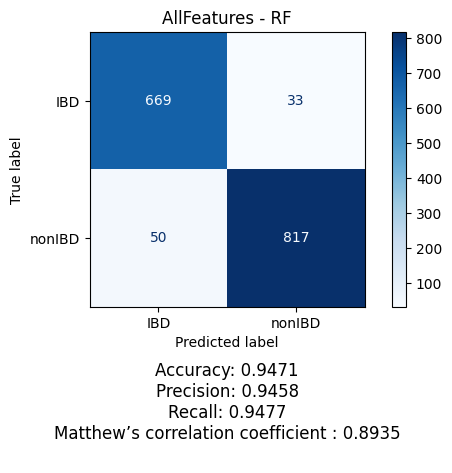

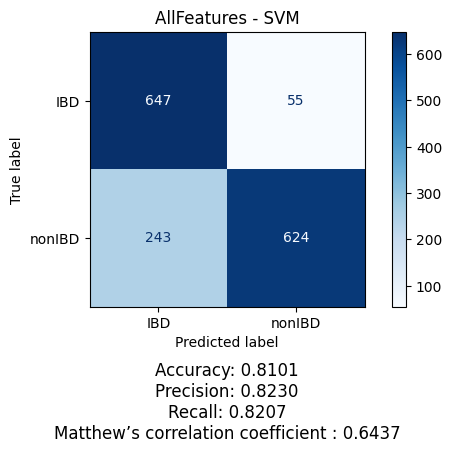

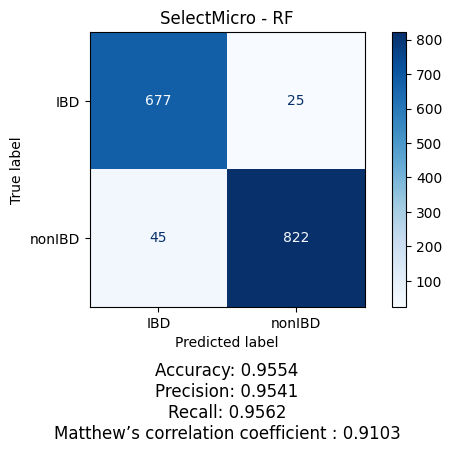

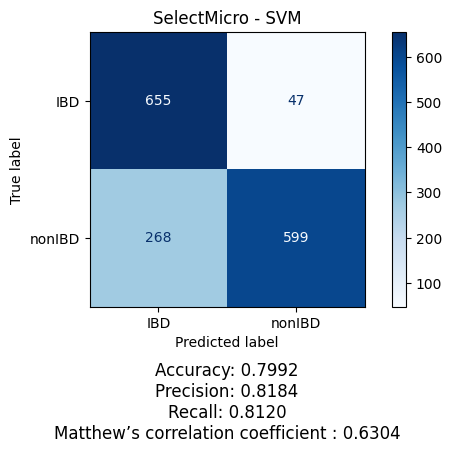

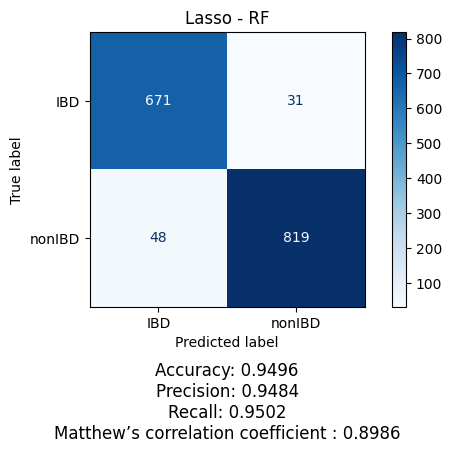

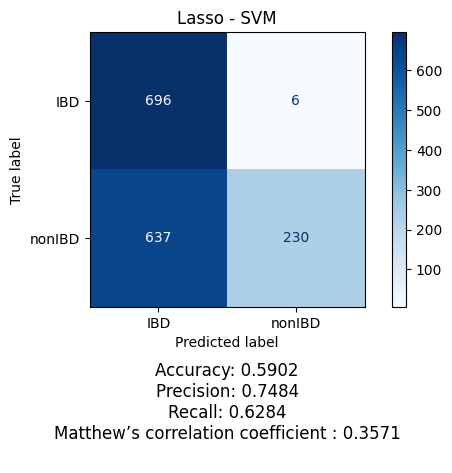

In [25]:
# do not use plotmacro_confusion_matrices (not for binary classification)
for dataset_name, classifiers in dict_cm.items():
        for classifier_name, labels in classifiers.items():
            actual_labels = labels[0]
            predicted_labels = labels[1]
            metric.plotmacro_confusion_matrices(actual_labels, predicted_labels,f"{dataset_name} - {classifier_name}")

## compare the first 15 index

In [26]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
# the   df with the largest H statistics features
entries=15
selectedOTU_index_15=selectedOTU_index[:entries]
X_FS_15=data[:,selectedOTU_index_15]
df=pd.DataFrame(data=X_FS_15)


In [27]:
# the column names of the featues
ASVs = cols_name
selectedASVs=[ASVs[i] for i in selectedOTU_index_15]

{'IBD', 'nonIBD'}
702 867


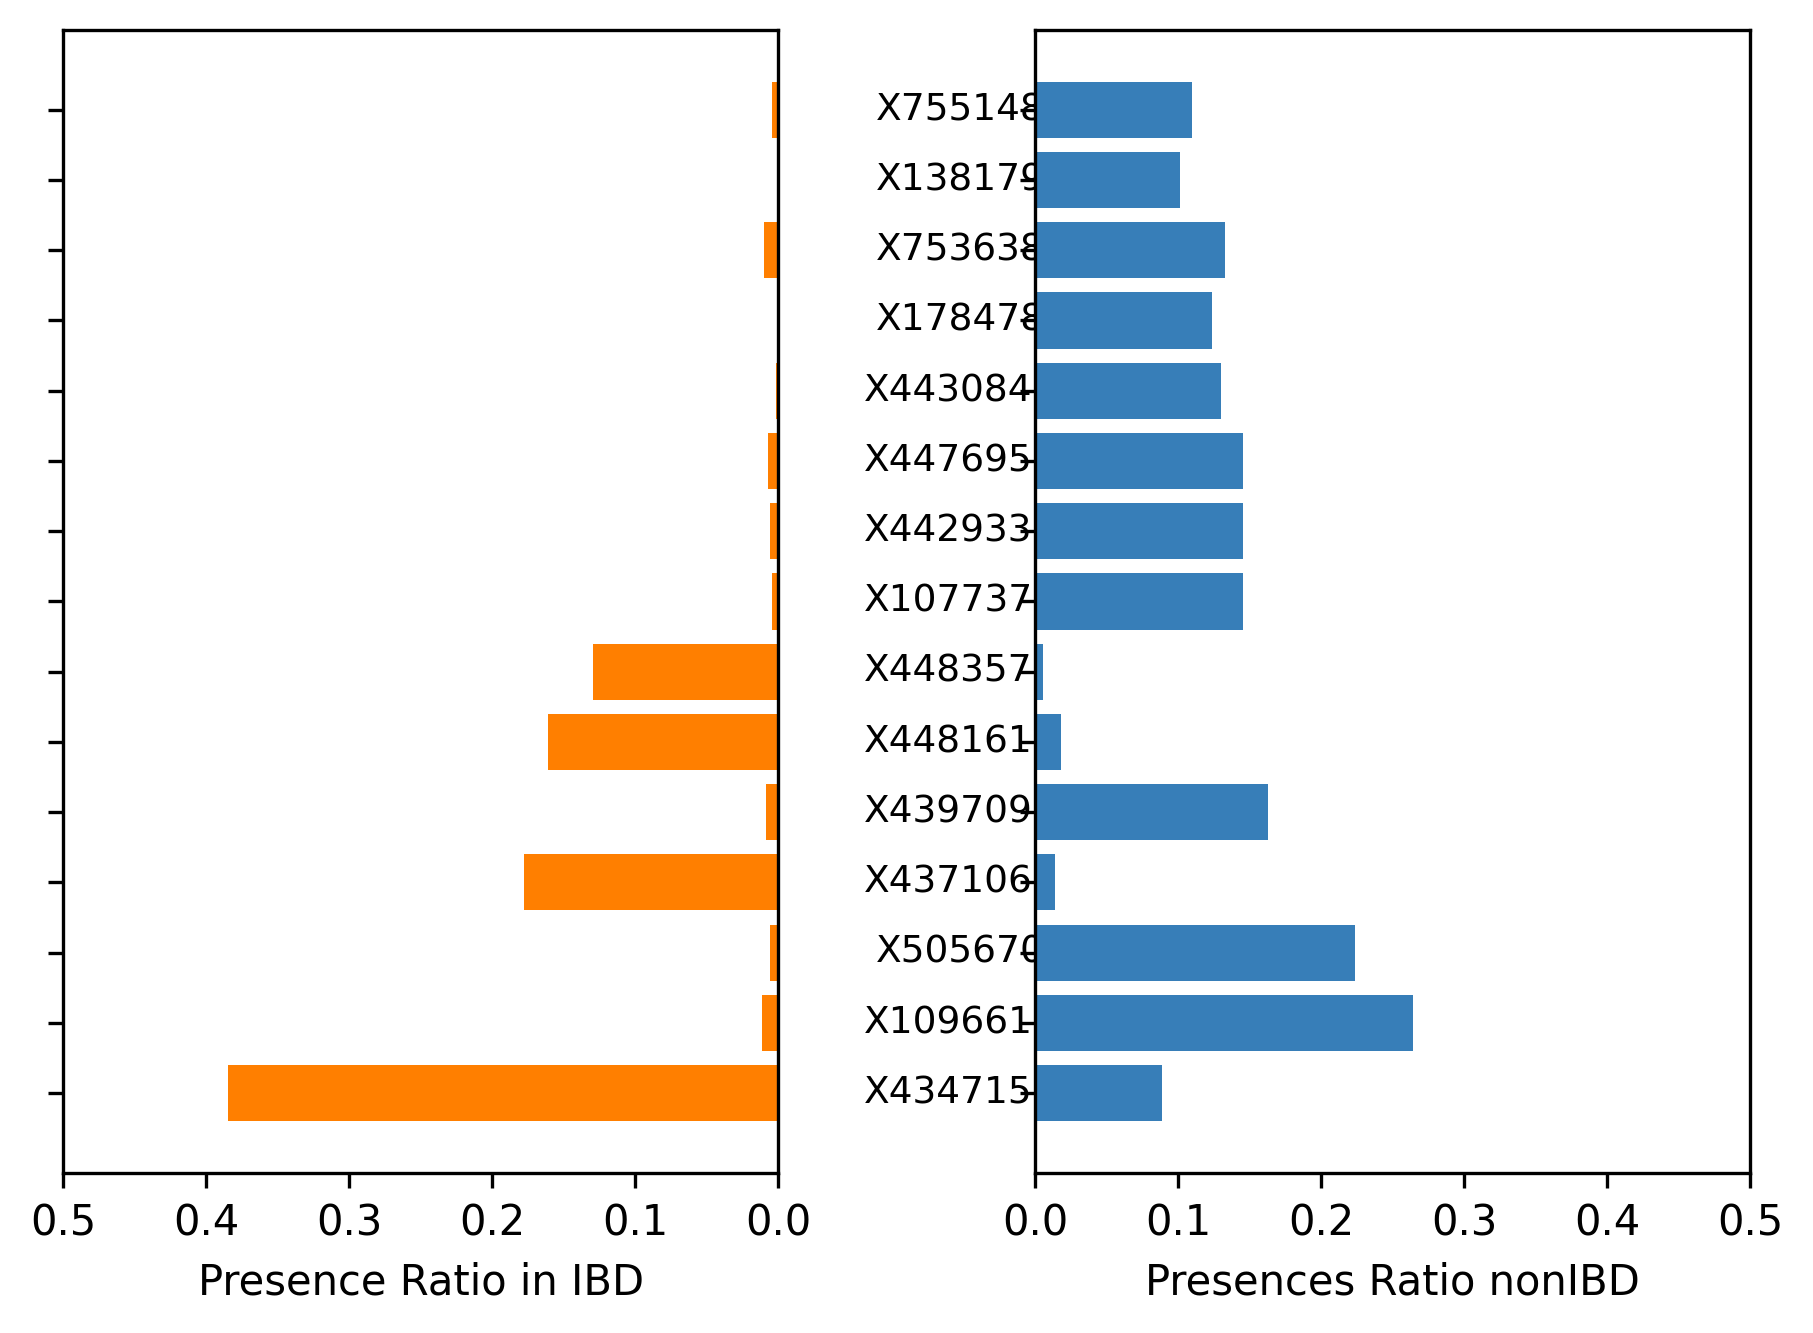

In [28]:
print(set(targetLabel))
RunML.plotPresenseRatio(X_FS_15,targetLabel,selectedASVs,posLabel="IBD",posText="IBD",negText="nonIBD",entries=entries)

702 867


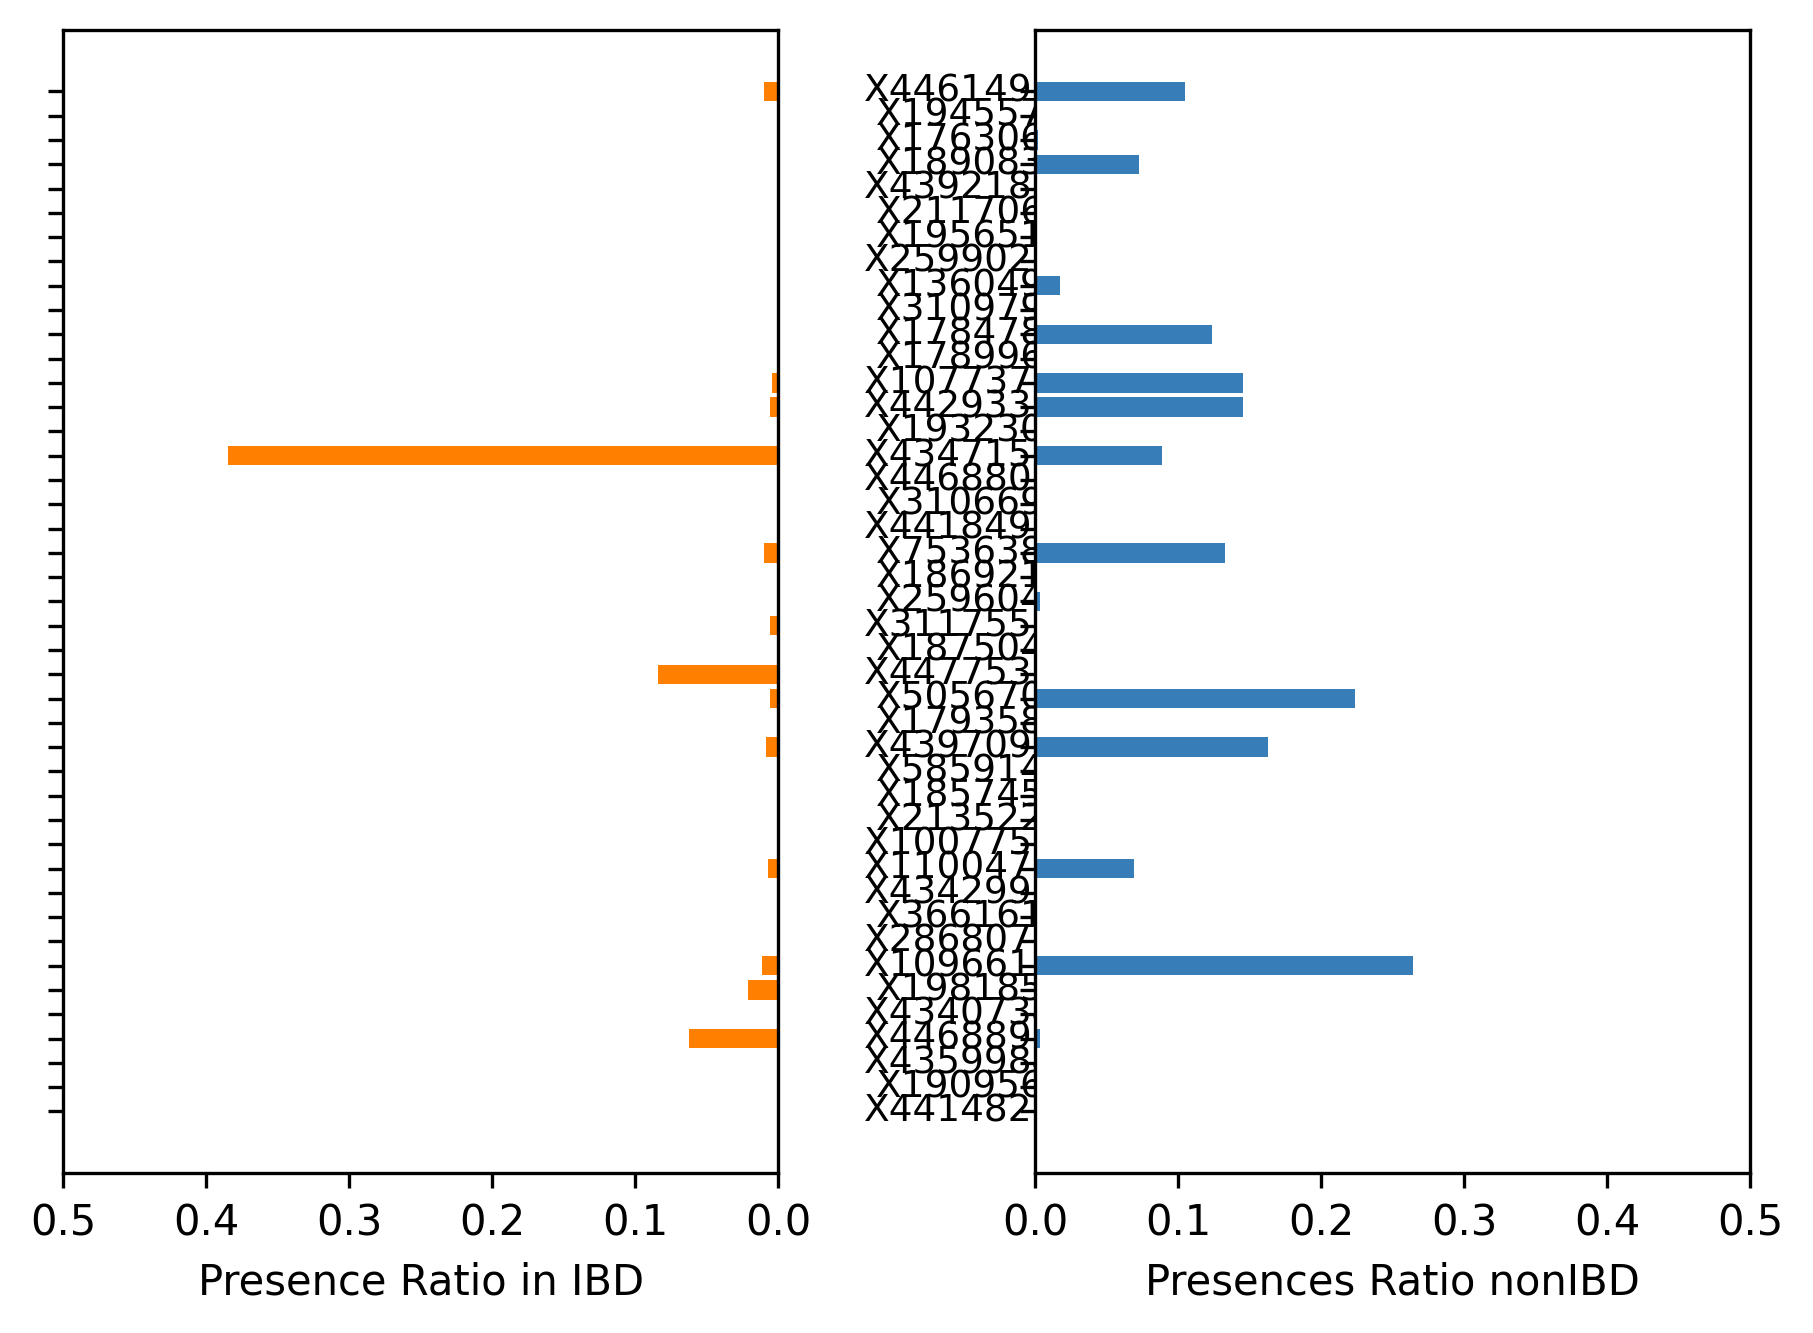

In [29]:
selectedASV_lasso = [cols_name[i] for i in xlabel_lasso]
RunML.plotPresenseRatio(X_lasso,targetLabel,selectedASV_lasso,posLabel="IBD",posText="IBD",negText="nonIBD",entries=len(selectedASV_lasso))

In [30]:
selectedASVs

['X4347159',
 'X1096610',
 'X505670',
 'X4371061',
 'X4397098',
 'X4481613',
 'X4483570',
 'X1077373',
 'X4429335',
 'X4476950',
 'X4430843',
 'X178478',
 'X753638',
 'X138179',
 'X755148']

In [31]:
qitta_combine[['Diagnosis','X4414821']].value_counts()

Diagnosis  X4414821
nonIBD     0           857
CD         0           301
UC         0           281
           1            34
CD         1            21
UC         2            18
           3            10
CD         2             6
nonIBD     1             6
UC         4             5
           5             4
           11            4
nonIBD     2             3
UC         6             2
           10            2
           14            2
           7             2
CD         4             2
           5             1
           19            1
           15            1
           9             1
           6             1
           3             1
UC         8             1
           21            1
nonIBD     3             1
Name: count, dtype: int64

In [32]:
selectedASV_lasso

['X4414821',
 'X190956',
 'X4359984',
 'X4468891',
 'X4340734',
 'X198185',
 'X1096610',
 'X2868079',
 'X366161',
 'X4342992',
 'X1100471',
 'X1007750',
 'X213522',
 'X185745',
 'X585914',
 'X4397098',
 'X179358',
 'X505670',
 'X4477537',
 'X187504',
 'X3117556',
 'X259604',
 'X186921',
 'X753638',
 'X4418496',
 'X310669',
 'X4468809',
 'X4347159',
 'X193230',
 'X4429335',
 'X1077373',
 'X178996',
 'X178478',
 'X310979',
 'X136049',
 'X2599028',
 'X195651',
 'X211706',
 'X4392183',
 'X189083',
 'X176306',
 'X194557',
 'X4461490']